# Install Requierment

In [ ]:
!pip install ultralytics

# Import Libraries

In [ ]:
# STEP 1: Import the necessary modules.

from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from skimage.io import  imread, imshow
import numpy as np
import cv2
from torch.serialization import save

# Model Functions

## For Images

In [ ]:
def segment_image(Source):

  # Load a model
  model = YOLO('yolov8n-seg.pt')

  # Model Prediction
  results = model.predict(Source)
  result = results[0]
  box = result.boxes

  # Get the size of the original image (height, width, channels)
  h2, w2, c2 = results[0].orig_img.shape

  # Create an empty alpha channel for the mask
  alpha = np.zeros((h2, w2), dtype=np.uint8)

  # Important
  for i, class_index in enumerate(box.cls):
    class_id = result.names[class_index.item()]

    if class_id == result.names[0]:
        if results[0].masks is not None:
            # Convert mask to single channel image
            mask_raw = results[0].masks[i].cpu().data.numpy().transpose(1, 2, 0)

            # Convert single channel grayscale to 3 channel image
            mask_3channel = cv2.merge((mask_raw, mask_raw, mask_raw))

            # Resize the mask to the same size as the image
            mask_resized = cv2.resize(mask_3channel, (w2, h2))

            # Extract the single channel mask
            mask = mask_resized[:, :, 0]

            # Set the alpha channel of the mask to full intensity (255) where the mask is non-zero
            alpha[np.where(mask > 0)] = 255

            # Add the alpha channel to the original image
            img_with_alpha = np.dstack((results[0].orig_img, alpha))

            # Convert the image to RGBA format
            img_rgba = cv2.cvtColor(img_with_alpha, cv2.COLOR_BGR2RGBA)

  # Show the masked image
  img_rgba = cv2.cvtColor(img_rgba, cv2.COLOR_BGR2RGBA)
  cv2_imshow(img_rgba)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

## For Videos

In [ ]:
def segment_video(Source):

  # Load a model
  model = YOLO('yolov8n-seg.pt')

  # Input and output video paths
  input_video_path = Source
  output_video_path = 'output1_video.mp4'

  # Model Prediction
  results = model.predict(Source)
  result = results[0]
  box = result.boxes

  # Create VideoCapture object
  cap = cv2.VideoCapture(input_video_path)

  # Get video frame dimensions
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Create VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

  # Read and process video frames
  while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # Perform object detection on the frame
    results = model.predict(frame)
    result = results[0]
    box = result.boxes

    # Create a blank black mask with the same size as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Process each detected object
    for i, class_index in enumerate(box.cls):
        class_id = result.names[class_index.item()]

        if class_id == result.names[0]:
            if results[0].masks is not None:
                # Convert mask to single channel image
                mask_raw = results[0].masks[i].cpu().data.numpy().transpose(1, 2, 0)

                # Resize the mask to the same size as the frame
                mask_resized = cv2.resize(mask_raw, (frame_width, frame_height))

                # Convert the mask to binary (0 or 255)
                mask_binary = np.where(mask_resized > 0, 255, 0).astype(np.uint8)

                # Apply the binary mask to the frame
                mask = cv2.bitwise_or(mask, cv2.bitwise_and(frame, frame, mask=mask_binary))

    # Write the masked frame to the output video file
    out.write(mask)

  # Release the resources
  cap.release()
  out.release()
  cv2.destroyAllWindows()

# Model

## For Images


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 skateboard, 265.8ms
Speed: 4.6ms preprocess, 265.8ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 480)


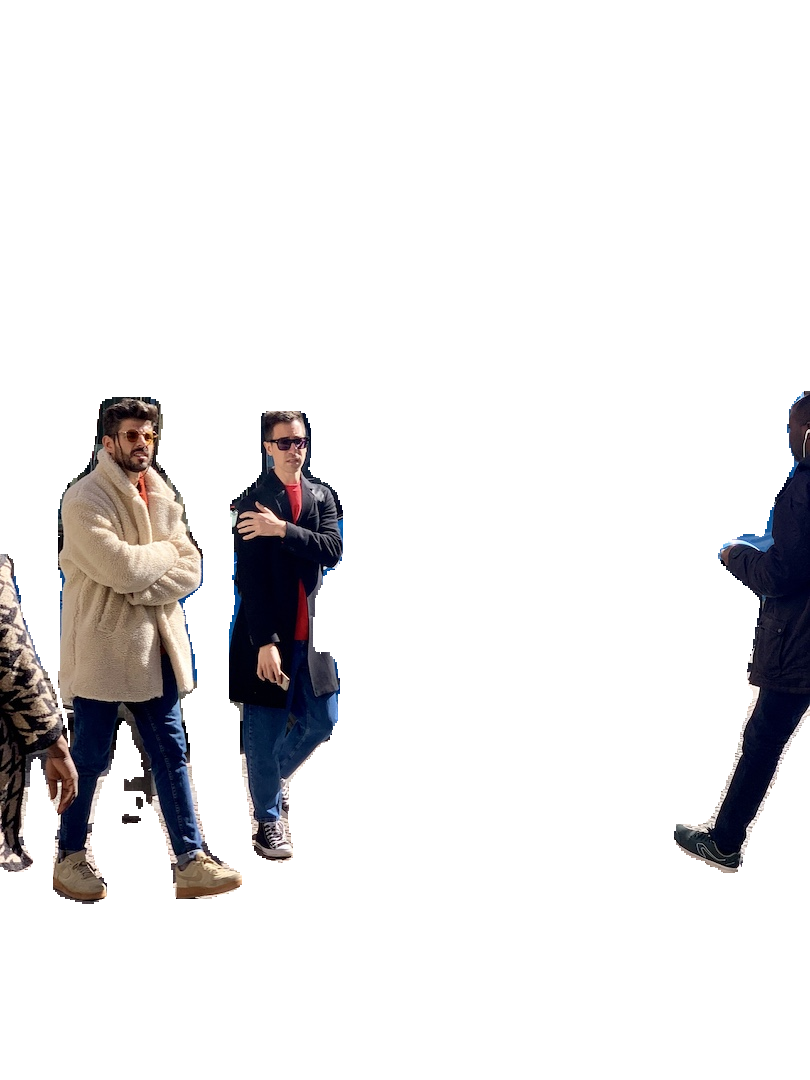

In [ ]:
segment_image('/content/bus.jpg')

## For Videos

In [ ]:
segment_video('/content/test - Trim.mp4')



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Example:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/909) /content/test - Trim.mp4: 384x640 5 persons, 5 cars, 1 traffic light, 457.0ms
video 1/1 (2/909) /content/test - Trim.mp4: 384x640 9 persons, 4 cars, 2 traffic lights, 309.1ms
video 1/1 (3/909) /content/test - Trim.mp4: 384x640 9 persons, 6 cars, 1 traffic light, 287.3ms
video 1/1 (4/909) /content/test - Trim.mp4: 384x640 8 persons, 3 cars, 2 traffic lights, 208.3ms
video 1/1 (5/909) /content/test - Trim.mp4: 384x640 8 persons, 1 car, 1